## DropConnect

En este notebook voy a realizar una implementación detallada y explicada de la técnica de regularización DropConnect usando la libreria PyTorch. Esta técnica es una generalización de Dropout, en la que en lugar de desactivar las neuronas de una capa, se desactivan las conexiones entre las neuronas de una capa y la siguiente.

Esta técnica es propuesta en el paper: [Regularization of Neural Networks using DropConnect](http://yann.lecun.com/exdb/publis/pdf/wan-icml-13.pdf).

Pero primero, voy a hacer un repaso de las funciónes ``Linear`` y ``Dropout`` y el producto de Hadamard de PyTorch, ya estas son utilizadas en la implementación de DropConnect y es preciso saber como estan implementadas y como se propagan los gradientes a traves de estas.

### Capas lineales

Sean:
- $\vec{x} \in \mathbb{R} ^ {d}$
- $W \in \mathbb{R} ^ {m \times d}$
- $\vec{b} \in \mathbb{R} ^ {m}$

Se define la función lineal como:

$$ \text{Linear}(\vec{x}, W, \vec{b}) = \vec{x}W^T + \vec{b} $$




Notemos que el elemento de la matriz transpuesta $(W^T)_i^j$ sera $w_j^i = w_i^j \delta^{ii} \delta_{jj}$, de modo que el producto $\vec{x}W^T$ sera:

$$ (\vec{x}W^T)_i = \sum_j x_j w_i^j \delta^{ii} \delta_{jj}$$

Derivando con respecto a los elementos de $W$ obtenemos:

$$ \frac{\partial (\vec{x} W^T)_i}{\partial w_k^l} 
 = \frac{(\partial \sum_j x_j w_i^j \delta^{ii} \delta_{jj})}{\partial w_k^l}
 = \sum_j x_j \delta^{ii} \delta_{jj} \frac{\partial w_i^j}{\partial w_k^l}
 = \sum_j x_j \delta^{ii} \delta_{jj} \delta_l^j \delta_i^k 
 = \delta^{ii} \delta_{ll} \delta_i^k x_l 
$$

Las deltas de Kronecker $\delta^{ii} \delta_{ll}$ y $\delta_i^k$ actuan transponiendolo y contrayendo una dimension de la derivada parcial, que paso a ser un tensor de rango 3, con esto en mente se puede probar que el gradiente propagado por la función lineal con respecto a $W$ sera:

$$ \vec{j} \frac{\partial \text{Linear}(\vec{x}, W, \vec{b})}{\partial W} = \vec{j} ^T \vec{x}$$

Analogamente, derivando con respecto a $\vec{b}$ obtenemos:

$$\vec{j}  \frac{\partial \text{Linear}(\vec{x}, W, \vec{b})}{\partial \vec{b}} = \vec{j} $$

Veamos esto ahora usando el mecanismo de diferenciación automática de Pytorch:

In [2]:
from torch import Tensor
from torch.nn import Parameter
from torch.nn.functional import linear

x = Tensor([1, 2, 3, 4, 5])
W = Parameter(data=Tensor([
    [1, 1, 1, 1, 1],
    [1, 3, 1, 1, 1],
    [1, 1, 1, 5, 1],
    [1, 1, 1, 1, 1],
    [2, 1, 1, 1, 1]
]))

b = Parameter(data=Tensor([1, 1, 1, 1, 1]))
j = Tensor([1, 2, 1, 4, 1])


y = linear(x, W, b)
y.backward(gradient=j)

print("Gradient calculated by PyTorch:")
print("Gradient of weight: ")
print(W.grad)
print("Gradient of bias: ")
print(b.grad)


print("Gradient calculated by hand:")
print("Gradient of weight: ")
print(j.unsqueeze(0).transpose(0,1) @ x.unsqueeze(0))
print("Gradient of bias: ")
print(j)


print("Gradient of weight: ")
print(x.unsqueeze(0).transpose(0,1) @ j.unsqueeze(0))

Gradient calculated by PyTorch:
Gradient of weight: 
tensor([[ 1.,  2.,  3.,  4.,  5.],
        [ 2.,  4.,  6.,  8., 10.],
        [ 1.,  2.,  3.,  4.,  5.],
        [ 4.,  8., 12., 16., 20.],
        [ 1.,  2.,  3.,  4.,  5.]])
Gradient of bias: 
tensor([1., 2., 1., 4., 1.])
Gradient calculated by hand:
Gradient of weight: 
tensor([[ 1.,  2.,  3.,  4.,  5.],
        [ 2.,  4.,  6.,  8., 10.],
        [ 1.,  2.,  3.,  4.,  5.],
        [ 4.,  8., 12., 16., 20.],
        [ 1.,  2.,  3.,  4.,  5.]])
Gradient of bias: 
tensor([1., 2., 1., 4., 1.])
Gradient of weight: 
tensor([[ 1.,  2.,  1.,  4.,  1.],
        [ 2.,  4.,  2.,  8.,  2.],
        [ 3.,  6.,  3., 12.,  3.],
        [ 4.,  8.,  4., 16.,  4.],
        [ 5., 10.,  5., 20.,  5.]])


El resultado es el mismo para tensores $X$ y $J$ de rango 2, siempre que $J^T X \in \mathbb{R} ^ {n \times d}$, en donde las dimensiones adicionales de $X$ y $J$ serian los tamaños de mini-batch.

En el caso del bias $\vec{b}$, el gradiente propagado con minibatch sera la suma de los gradientes de cada elemento del mini-batch.

In [3]:
from torch import Tensor
from torch.nn import Parameter
from torch.nn.functional import linear

X = Tensor([
    [1, 2, 3],
    [4, 5, 6]
])

W = Parameter(data=Tensor([
    [1, 1, 1],
    [1, 3, 1],
    [1, 1, 1],
    [1, 1, 1]
]), requires_grad=True)	

b = Parameter(data=Tensor([1, 1, 1, 1]), requires_grad=True)

J = Tensor([
    [1, 2, 1, 4],
    [1, 1, 1, 1]
])

y = linear(X, W, b)
y.backward(gradient=J)

print("Gradient of bias: ")
print(b.grad)

print(J.sum(dim=0))

Gradient of bias: 
tensor([2., 3., 2., 5.])
tensor([2., 3., 2., 5.])


### Producto de Hadamard (Element-wise producto)

Dadas dos matrices $X, Y \in \mathbb{R}^{d \times n}$ de las mismas dimensiones, el producto de Hadamard se define como:

$$ X \odot Y = \begin{bmatrix} 

    x_1^1 & x_2^1 & \cdots & x_d^1 \\
    x_1^2 & x_2^2 & \cdots & x_d^2 \\
    \vdots & \vdots & \ddots & \vdots \\
    x_1^n & x_2^n & \cdots & x_d^n \\

\end{bmatrix} \odot \begin{bmatrix}

    y_1^1 & y_2^1 & \cdots & y_d^1 \\
    y_1^2 & y_2^2 & \cdots & y_d^2 \\
    \vdots & \vdots & \ddots & \vdots \\
    y_1^n & y_2^n & \cdots & y_d^n \\

\end{bmatrix} = \begin{bmatrix}

    x_1^1 y_1^1 & x_2^1 y_2^1 & \cdots & x_d^1 y_d^1 \\
    x_1^2 y_1^2 & x_2^2 y_2^2 & \cdots & x_d^2 y_d^2 \\
    \vdots & \vdots & \ddots & \vdots \\
    x_1^n y_1^n & x_2^n y_2^n & \cdots & x_d^n y_d^n \\

\end{bmatrix} $$



Notemos que:

$$ \frac{\partial (X \odot Y)_i^j}{\partial x_k^l}
 = \frac{\partial ( x_i^j y_i^j )}{\partial x_k^l}
 = y_i^j \frac{\partial x_i^j}{\partial x_k^l}
 = y_i^j \delta_l^j \delta_i^k
$$

De modo que, dado un gradiente $J$ proveniente de una operación posterior, el gradiente propagado por el producto de Hadamard con respecto a $X$ sera:

$$ \sum_{k l} J_k^l \frac{\partial (X \odot Y)_i^j}{\partial x_k^l} = \sum_{k l} J_k^l y_i^j \delta_l^j \delta_i^k = J_i^j Y_i^j \rightarrow J \odot Y $$

Analogamente, el gradiente propagado con respecto a $Y$ sera: 

$$ J \odot X $$

In [4]:
from torch import Tensor
from torch.nn import Parameter
from torch.nn.functional import linear

X = Parameter(data=Tensor([
    [0, 2, 3, 4, 5],
    [1, 3, 0, 4, 5],
    [1, 2, 3, 4, 5],
    [0, 2, 3, 4, 5],
    [5, 2, 3, 4, 5]
]))

Y = Parameter(data=Tensor([
    [1, 2, 1, 2, 1],
    [1, 2, 0, 4, 1],
    [2, 2, 1, 4, 1],
    [1, 1, 1, 5, 1],
    [1, 2, 5, 1, 3]
]))

result = X * Y
J = Tensor([
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 0, 1, 0, 1],
    [1, 1, 0, 1, 0],
    [1, 1, 1, 1, 1]
])

result.backward(gradient=J)

print("Gradients calculated by PyTorch:")
print(X.grad)
print(Y.grad)

print("Gradients calculated by hand:")
print(J * Y)
print(J * X)

Gradients calculated by PyTorch:
tensor([[1., 2., 1., 2., 1.],
        [1., 2., 0., 4., 1.],
        [2., 0., 1., 0., 1.],
        [1., 1., 0., 5., 0.],
        [1., 2., 5., 1., 3.]])
tensor([[0., 2., 3., 4., 5.],
        [1., 3., 0., 4., 5.],
        [1., 0., 3., 0., 5.],
        [0., 2., 0., 4., 0.],
        [5., 2., 3., 4., 5.]])
Gradients calculated by hand:
tensor([[1., 2., 1., 2., 1.],
        [1., 2., 0., 4., 1.],
        [2., 0., 1., 0., 1.],
        [1., 1., 0., 5., 0.],
        [1., 2., 5., 1., 3.]], grad_fn=<MulBackward0>)
tensor([[0., 2., 3., 4., 5.],
        [1., 3., 0., 4., 5.],
        [1., 0., 3., 0., 5.],
        [0., 2., 0., 4., 0.],
        [5., 2., 3., 4., 5.]], grad_fn=<MulBackward0>)


### Distribución de Bernoulli.

En el dropout, se desactivan neuronas de la red con el objetivo de evitar el sobreajuste y mejorar la generalización de la red neuronal.. Cada neurona tiene una probabilidad de ser desactivada (o "droppeada") durante el entrenamiento. 

Se puede leer más sobre dropout en el siguiente [artículo](https://arxiv.org/pdf/1207.0580).

Para ello se utiliza la distribución de Bernoulli, esta es una distribución de probabilidad discreta que modela la probabilidad de un evento binario, es decir, un evento que puede tener solo dos resultados posibles: éxito (1) o fracaso (0). En el caso del dropout, el evento binario es la activación o desactivación de una neurona.

La distribución de Bernoulli se define como:

- $P(X = 1) = p$
- $P(X = 0) = 1 - p$

Donde p es la probabilidad de que la neurona sea activada. Veamos un poco esta distribución.

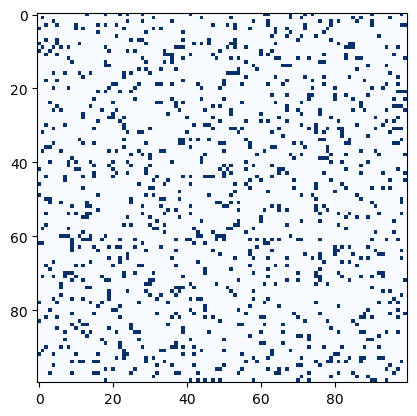

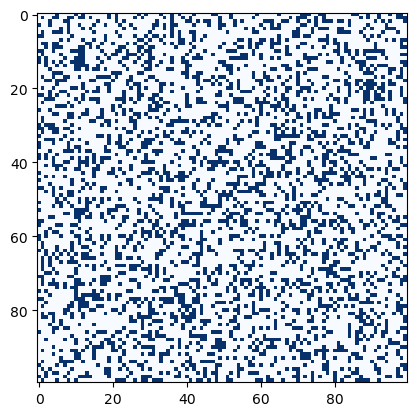

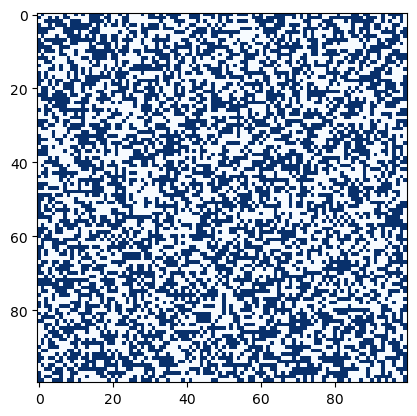

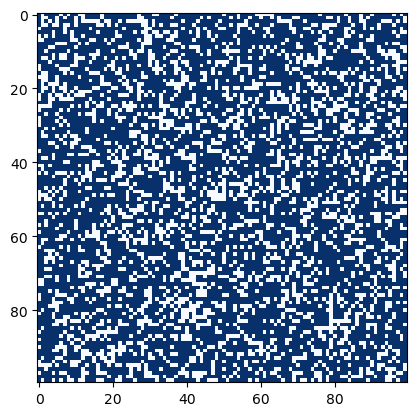

In [5]:
from torch import Tensor
from torch import bernoulli

from matplotlib.pyplot import figure, show

for probability in [0.1, 0.3, 0.5, 0.7]:
    distrubution = bernoulli(input =  Tensor(100, 100), p = probability)
    plot = figure()
    ax = plot.add_subplot()
    ax.imshow(distrubution, cmap='Blues', interpolation='nearest')

En las figuras, se muestra la distribución de Bernoulli para diferentes valores de p en un tensor. En azul las neuronas desactivadas.

### DropOut y DropConnect

En el paper [DropConnect](http://yann.lecun.com/exdb/publis/pdf/wan-icml-13.pdf) se propone una generalización del dropout, donde en lugar de desactivar las neuronas, se desactivan las conexiones.

![alt text](https://cds.nyu.edu/wp-content/uploads/2014/04/Capture1.png)

### Entrenamiento

Para el entrenamiento, se crea una matriz de máscara $M$ desde una distribución de Bernoulli para enmascarar elementos de una matriz de pesos $W$, usando el producto de Hadamard: 

$$M \odot W $$

Para entrenar con éxito con DropConnect, se debe seleccionar una máscara diferente para cada ejemplo de entrenamiento, seleccionar una sola máscara para un subconjunto de ejemplos de entrenamiento, como un minilote de 128 ejemplos, no regulariza lo suficiente el modelo en la práctica. Dado que el requisito de memoria para las matrices $M$ ahora crece con el tamaño de cada minilote, la implementación necesita ser diseñada con cuidado, ya que podría haber problemas con la memoria.

Luego se propagan los gradientes de la función de pérdida con respecto a los parámetros, $J$. 

Para actualizar la matriz de pesos $W$ en una capa DropConnect, se aplica la máscara al gradiente para actualizar solo aquellos elementos que estuvieron activos en la pasada hacia adelante.

Sin embargo esto ya se realiza en la propagación del producto de Hadamard, ya que si $J$ es el gradiente proveniente de la opración lineal, el gradiente propagado por el producto de Hadamard con respecto a $W$ sera:

$$ J \odot M $$

Por lo que no hace falta implementar una operación de backpropagation adicional, y solo se necesita utilizar el producto de Hadamard ya provisto por Pytorch.

#### Implementación

Para implementar la capa lineal con DropConnect, se debe precomputar las mascara $M$ de la distribución de Bernoulli y aplicarla al tensor de pesos $W$ en la operación de forward. Debido a que la máscara $M$ es diferente para cada ejemplo de entrenamiente, lo que se puede hacer es establecer un valor máximo del tamaño de minilotes y precomputar todas la máscaras posibles, y luego seleccionar una máscara diferente para cada minilote de ejemplos.

Afortunadamente, PyTorch tiene implementaciones de tensores de valores booleanos y de la operación de mascara.


In [6]:
import torch
from torch.nn import Parameter

mask = torch.bernoulli(torch.zeros(5,5, dtype=torch.bool, device='cpu'), 0.6)
weight = Parameter(torch.randn(5,5, device='cpu'), requires_grad=True)
gradient = torch.rand(5,5, device='cpu')

output = torch.masked_fill(weight, mask, 0)
output.backward(gradient)

print(mask)
print(weight.grad)

tensor([[ True, False,  True, False,  True],
        [ True,  True,  True, False, False],
        [False,  True,  True,  True,  True],
        [ True, False, False,  True,  True],
        [ True,  True,  True, False, False]])
tensor([[0.0000, 0.1484, 0.0000, 0.2404, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.7249, 0.7696],
        [0.7249, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0936, 0.7772, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.2945, 0.5978]])


Sean:

- $X \in \mathbb{R}^{n \times d}$ : Un tensor de entrada con $n$ ejemplos y $d$ características.
- $W \in \mathbb{R}^{l \times d}$ : Un tensor de pesos.

Para un solo ejemplo, la implementación es sencilla, simplemente se le aplica una mascara $M$ a un tensor de pesos $W$. Sin embargo, segun el paper: " A key component to successfully training with DropConnect is the selection of a different mask for each training example. Selecting a single mask for a subset of training examples, such as a mini-batch of 128 examples, does not regularize the model enough in practice "

De modo que se tiene que elegir un tensor de mascara $M \in \mathbb{R} ^ { n \times l \times d }$, por lo que la capa lineal con DropConnect debe ser implementada como:

$$ \text{DropConnect}(X, W, M) = \begin{bmatrix} \begin{bmatrix}  x_1^1 & x_2^1 & \cdots & x_d^1 \end{bmatrix}
(\begin{bmatrix} 
m_1^{11} & m_2^{11} & \cdots & m_d^{11} \\
m_1^{12} & m_2^{12} & \cdots & m_d^{12} \\
\vdots & \vdots & \ddots & \vdots \\
m_1^{1l} & m_2^{1l} & \cdots & m_d^{1l} \\
\end{bmatrix} \odot \begin{bmatrix}
w_1^1 & w_2^1 & \cdots & w_d^1 \\
w_1^2 & w_2^2 & \cdots & w_d^2 \\
\vdots & \vdots & \ddots & \vdots \\
w_1^l & w_2^l & \cdots & w_d^l \\
\end{bmatrix}
)^T \\
\\
\begin{bmatrix}  x_1^2 & x_2^2 & \cdots & x_d^2 \end{bmatrix}
(\begin{bmatrix} 
m_2^{21} & m_2^{21} & \cdots & m_d^{21} \\
m_1^{22} & m_2^{22} & \cdots & m_d^{22} \\
\vdots & \vdots & \ddots & \vdots \\
m_1^{2l} & m_2^{2l} & \cdots & m_d^{2l} \\
\end{bmatrix} \odot \begin{bmatrix}
w_1^1 & w_2^1 & \cdots & w_d^1 \\
w_1^2 & w_2^2 & \cdots & w_d^2 \\
\vdots & \vdots & \ddots & \vdots \\
w_1^l & w_2^l & \cdots & w_d^l \\
\end{bmatrix}
)^T \\
\\ \vdots   \\
\\
\begin{bmatrix}  x_1^n & x_2^n & \cdots & x_d^n \end{bmatrix}
(\begin{bmatrix} 
m_1^{n1} & m_2^{n1} & \cdots & m_d^{n1} \\
m_1^{n2} & m_2^{n2} & \cdots & m_d^{n2} \\
\vdots & \vdots & \ddots & \vdots \\
m_1^{nl} & m_2^{nl} & \cdots & m_d^{nl} \\
\end{bmatrix} \odot \begin{bmatrix}
w_1^1 & w_2^1 & \cdots & w_d^1 \\
w_1^2 & w_2^2 & \cdots & w_d^2 \\
\vdots & \vdots & \ddots & \vdots \\
w_1^l & w_2^l & \cdots & w_d^l \\
\end{bmatrix}
)^T
\end{bmatrix} 

Esto puede ser logrado primero expandiendo primero el tensor $X$ al espacio $ \mathbb{R}^{n \times 1 \times d} $, de modo que ahora las multiplicacion del tensor $X$ por el producto $(M \odot W)^T$ se hara por broadcasting, y cada fila de $X$ sera multiplicada por una mascara diferente, como el paper indica.

Veamos esto en PyTorch:

In [7]:
from torch import Tensor

X = Tensor([
    [1, 2],
    [3, 4],
    [5, 6]
])

W = Tensor([
    [1, 1],
    [1, 1]
])

M = Tensor([
    [
        [1, 0],
        [1, 0]
    ],
    [
        [0, 1],
        [0, 1]
    ],
    [
        [0, 0],
        [1, 0]
    ]
])

print("Se busca para cada fila de X, multiplicarla por el producto de W y M")
for row in range(X.size(0)):
    print(X[row] @ (M[row]*W).T)


print("puede ser optimizado con broadcasting:")
print((X.unsqueeze(1)@(M*W).transpose(1,2)).squeeze())

Se busca para cada fila de X, multiplicarla por el producto de W y M
tensor([1., 1.])
tensor([4., 4.])
tensor([0., 5.])
puede ser optimizado con broadcasting:
tensor([[1., 1.],
        [4., 4.],
        [0., 5.]])


Probemos el resultado con mascaras de booleanos.

In [8]:
import torch
from torch.nn import Parameter

input = torch.randn(3, 5, device='cpu')
mask = torch.bernoulli(torch.zeros(3,5,5, dtype=torch.bool, device='cpu'), 0.6)
weight = Parameter(torch.randn(5,5, device='cpu'), requires_grad=True)

for row in range(input.size(0)):
    print(input[row]@torch.masked_fill(weight, mask[row], 0).T)

output = (input.unsqueeze(1)@torch.masked_fill(weight, mask, 0).transpose(1,2)).squeeze()
print(output)

tensor([ 2.2205,  0.5500, -0.6019,  1.3555, -0.9028],
       grad_fn=<SqueezeBackward4>)
tensor([-0.2952, -1.0051, -0.1380, -0.3091,  3.7341],
       grad_fn=<SqueezeBackward4>)
tensor([0.6368, 3.0855, 1.2035, 0.7113, 2.0979], grad_fn=<SqueezeBackward4>)
tensor([[ 2.2205,  0.5500, -0.6019,  1.3555, -0.9028],
        [-0.2952, -1.0051, -0.1380, -0.3091,  3.7341],
        [ 0.6368,  3.0855,  1.2035,  0.7113,  2.0979]],
       grad_fn=<SqueezeBackward0>)


Segun el paper, la capa lineal con bias es implementada expandiendo las dimensiones de la matriz de pesos $W$ con los parametros de $\vec{b}$ y la matriz de entrada $X$ con unos de la siguiente manera:

$$ \text{Linear}(\vec{x}, W, \vec{b}) = 

\begin{bmatrix} x_1 & x_2 & \cdots & x_d & 1 \end{bmatrix}

\begin{bmatrix} w_1^1 & w_2^1 & \cdots & w_d^1 & b^1 \\ w_1^2 & w_2^2 & \cdots & w_d^2 & b^2 \\ \vdots & \vdots & \ddots & \vdots & \vdots \\ w_1^n & w_2^n & \cdots & w_d^n & b^n \end{bmatrix} ^ T

$$


De modo que si tenemos una mascara $M$ aplicada a una matriz de pesos de esta forma, debemos añadir una columna a cada dimensión de $M$. PyTorch sin embargo, implementa la capa lineal simplemente sumando el bias con broadcasting (En CPU, desconozco como se implementa en GPU), de modo que por el momento nos apegaremos a la implementación de PyTorch y añadiremos una mascara de bias distinta para cada ejemplo de entrenamiento, a la cual denominaremos $M_b$.




In [9]:
import torch
from torch.nn import Parameter

input = torch.randn(3, 5, device='cpu')
mask = torch.bernoulli(torch.zeros(3,5,5, dtype=torch.bool, device='cpu'), 0.6)
bias_mask = torch.bernoulli(torch.zeros(3,5, dtype=torch.bool, device='cpu'), 0.6)
weight = Parameter(torch.randn(5,5, device='cpu'), requires_grad=True)
bias = Parameter(torch.randn(5, device='cpu'), requires_grad=True)

for row in range(input.size(0)):
    print(input[row]@torch.masked_fill(weight, mask[row], 0).T)

output = (input.unsqueeze(1)@torch.masked_fill(weight, mask, 0).transpose(1,2)).squeeze()
print(output)


for row in range(input.size(0)):
    print(input[row]@torch.masked_fill(weight, mask[row], 0).T + torch.masked_fill(bias, bias_mask[row], 0))

output = (input.unsqueeze(1)@torch.masked_fill(weight, mask, 0).transpose(1,2)).squeeze() + torch.masked_fill(bias, bias_mask, 0)
print(output)

tensor([-2.4750,  0.6700, -1.2219, -1.5489,  3.3033],
       grad_fn=<SqueezeBackward4>)
tensor([ 1.1675, -0.3272,  0.3766,  0.0000,  1.1420],
       grad_fn=<SqueezeBackward4>)
tensor([ 0.7673, -0.7816, -0.0370, -0.1106,  0.7874],
       grad_fn=<SqueezeBackward4>)
tensor([[-2.4750,  0.6700, -1.2219, -1.5489,  3.3033],
        [ 1.1675, -0.3272,  0.3766,  0.0000,  1.1420],
        [ 0.7673, -0.7816, -0.0370, -0.1106,  0.7874]],
       grad_fn=<SqueezeBackward0>)
tensor([-2.8378,  0.7741, -2.8473, -1.5489,  3.3033], grad_fn=<AddBackward0>)
tensor([ 0.8047, -0.3272, -1.2487,  0.0000,  1.1430], grad_fn=<AddBackward0>)
tensor([ 0.7673, -0.7816, -0.0370, -0.1106,  0.7884], grad_fn=<AddBackward0>)
tensor([[-2.8378,  0.7741, -2.8473, -1.5489,  3.3033],
        [ 0.8047, -0.3272, -1.2487,  0.0000,  1.1430],
        [ 0.7673, -0.7816, -0.0370, -0.1106,  0.7884]], grad_fn=<AddBackward0>)


### Inferencia

Para la inferencia, se debe computar según el paper:

$$\frac{1}{|M|} \sum_M X \cdot (M \odot W)$$

Sin embargo, esto es muy costoso computacionalmente, por lo que el mismo paper propone una manera alternativa. 
Notemos que la salida de la capa lineal aplicando la máscara $M$ es:

$$\sum_k X_k^i W_j^k \delta_{ii} \delta^{jj} M_i^j = \sum_k W_k^j X_i^k M_i^j \quad \text{para el elemento $i$, $j$}$$ 

Esto es una suma pesada de los elementos $M_i^j$ de la distribución de Bernoulli que puede ser aproximada por una distribución gaussiana $N(\Mu,\Sigma^2)$ con media:

$$\Mu_M[X] = p X W^T$$

Y varianza:

$$\Sigma^2_M[X] = p(1 - p) (X \odot X) (W^T \odot W^T)$$

Es decir, el resultado de la capa $\text{DropConnect}$ con probabilidad $p$, durante la inferencia, es el tensor cuyos elementos esta determinados por una distribución gaussiana de media $\Mu_M[X]$ y varianza $\Sigma^2_M[X]$.


#### Implementación

Para implementar la inferencia, pueden computarse las medias y varianzas de la distribución gaussiana, y simplemente utilizar la implementación de la distribución gaussiana de PyTorch para obtener una aproximación de la salida de la capa $\text{DropConnect}$ durante la inferencia.

In [10]:
import torch
from torch import Tensor
from torch.distributions.normal import Normal

X = Tensor([
    [1, 2],
    [3, 4],
    [5, 6]
])

W = Tensor([
    [1, 1],
    [1, 1]
])

p = 0.3


mean = p*X @ W.T
variance = p*(1-p)*X**2 @ W.T**2

output = Normal(mean, variance.sqrt())

print(output.sample())

tensor([[ 3.0222,  0.2475],
        [ 1.1349, -2.2698],
        [ 7.4715,  6.7327]])


Implementamos finalmente las funciones necesarias de la capa drop connect para entrenamiento e inferencia. Modificamos la capa ``Linear`` de PyTorch para crear la capa ``DropConnect``.

In [11]:
from typing import Optional
import torch
import math
from torch import Tensor
from torch.nn import Parameter
from torch.nn import Module
from torch.nn import init
from torch.nn.functional import linear
from torch.distributions.normal import Normal

def drop_connect_training(input: Tensor, mask: Tensor, weight: Tensor, bias: Optional[Tensor] = None, bias_mask: Optional[Tensor] = None) -> Tensor:
    input = (input.unsqueeze(1)@torch.masked_fill(weight, mask, 0).transpose(1,2)).squeeze()
    if bias is not None:
        assert bias_mask is not None , "bias mask is required when bias is provided"
        input = input + torch.masked_fill(bias, bias_mask, 0)
    return input

def drop_connect_inference(input: Tensor, weight: Tensor, p: float, bias: Optional[Tensor] = None) -> Tensor:
    mean = (1-p)*linear(input, weight,bias)
    variance = p*(1-p)*input**2 @ weight.T**2
    return  Normal(mean, variance.sqrt()).sample()

class DropConnectLinear(Module):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True, p: float = 0.5 , max_batch_size: int = 512, device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.max_batch_size = max_batch_size
        self.p = p
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        self.weight_mask = Parameter(
            data=torch.bernoulli(torch.zeros(max_batch_size, out_features, in_features, dtype=torch.bool, device=device), p),
            requires_grad=False)
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
            self.bias_mask = Parameter(
                data=torch.bernoulli(torch.zeros(max_batch_size, out_features, dtype=torch.bool, device=device), p),
                requires_grad=False)
            
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        if self.training:
            return drop_connect_training(input, self.weight_mask[:input.size(0)], self.weight, self.bias, self.bias_mask[:input.size(0)])
        else:
            return drop_connect_inference(input, self.weight, self.p, self.bias)

    def extra_repr(self) -> str:
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}'


Probemos ahora la capa ``DropConnect`` con un ejemplo de clasificación de dígitos de MNIST, comparandola con un perceptrón multicapa utilizando dropout.

In [12]:
from torch import Tensor
from torch.nn import Module, Sequential
from torch.nn import Linear, Dropout, ReLU
from torch.nn import Flatten

class Perceptron(Module):
    def __init__(self, input_features: int, hidden_dimension: int, output_features: int, p: float):
        super().__init__()
        self.flatten = Flatten()
        self.layers = Sequential(
            Linear(input_features, hidden_dimension),
            ReLU(),
            Dropout(p),
            Linear(hidden_dimension, hidden_dimension),
            ReLU(),
            Dropout(p),
            Linear(hidden_dimension, output_features)
        )

    def forward(self, input: Tensor) -> Tensor:
        input = self.flatten(input)
        return self.layers(input)

In [13]:
from typing import Iterator, Tuple, Protocol
from torch import argmax
from torch import Tensor
from torch.nn import Module
from torch.optim import Optimizer

class Criterion(Protocol):
    def __call__(self, input: Tensor, target: Tensor) -> Tensor:
        ...

class Dataloader(Protocol):
    def __iter__(self) -> Iterator[Tuple[Tensor, Tensor]]:
        ...

def train(model: Module, criterion: Criterion, optimizer: Optimizer, data: Dataloader, device: str) -> Tuple[float, float]:
    model.train()    
    model.to(device)

    average_loss = 0
    average_precision = 0

    for batch, (input, target) in enumerate(data, start=1):
        input, target = input.to(device), target.to(device)
        input.flatten(1,2)
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        average_loss += loss.item()
        average_precision += (argmax(output, dim=1) == target).float().mean().item()

    average_loss /= batch
    average_precision /= batch

    return average_loss, average_precision

def test(model: Module, criterion: Criterion, data: Dataloader, device: str) -> Tuple[float, float]:
    with torch.no_grad():
        model.eval()
        model.to(device)

        average_loss = 0
        average_precision = 0

        for batch, (input, target) in enumerate(data, start=1):
            input, target = input.to(device), target.to(device)
            input.flatten(1,2)
            output = model(input)
            loss = criterion(output, target)    

            average_loss += loss.item()
            average_precision += (argmax(output, dim=1) == target).float().mean().item()

    average_loss /= batch
    average_precision /= batch

    return average_loss, average_precision
        

In [14]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
train_dataset = MNIST(root='data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='data', train=False, download=True, transform=transform)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=64, 
    shuffle=True, 
    pin_memory=True,
    pin_memory_device=device,
    num_workers=8    
)

test_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=64, 
    shuffle=False, 
    pin_memory=True,
    pin_memory_device=device,
    num_workers=8    
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [15]:
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

model = Perceptron(28*28, 256, 10, 0.5)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

torch.set_float32_matmul_precision('high')
torch.compile(model)

for epoch in range(1, 6):
    train_loss, train_precision = train(model, criterion, optimizer, train_loader, device)
    test_loss, test_precision = test(model, criterion, test_loader, device)
    print(f"Epoch {epoch}: Train Loss {train_loss:.6f} Train Precision {train_precision:.6f} Test Loss {test_loss:.6f} Test Precision {test_precision:.6f}")

Epoch 1: Train Loss 0.380549 Train Precision 0.882996 Test Loss 0.135689 Test Precision 0.959405
Epoch 2: Train Loss 0.214713 Train Precision 0.936650 Test Loss 0.098051 Test Precision 0.971032
Epoch 3: Train Loss 0.180807 Train Precision 0.946312 Test Loss 0.079159 Test Precision 0.976479
Epoch 4: Train Loss 0.164808 Train Precision 0.949544 Test Loss 0.065637 Test Precision 0.980627
Epoch 5: Train Loss 0.154913 Train Precision 0.953441 Test Loss 0.064275 Test Precision 0.980644


In [16]:
class DropConnectPerceptron(Module):
    def __init__(self, input_features: int, hidden_dimension: int, output_features: int, p: float):
        super().__init__()
        self.flatten = Flatten()
        self.layers = Sequential(
            DropConnectLinear(input_features, hidden_dimension, p=p),
            ReLU(),
            DropConnectLinear(hidden_dimension, hidden_dimension, p=p),
            ReLU(),
            Linear(hidden_dimension, output_features)
        )

    def forward(self, input: Tensor) -> Tensor:
        input = self.flatten(input)
        return self.layers(input)

In [17]:
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

model = DropConnectPerceptron(28*28, 256, 10, 0.5)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

torch.set_float32_matmul_precision('high')
torch.compile(model)

for epoch in range(1, 6):
    train_loss, train_precision = train(model, criterion, optimizer, train_loader, device)
    test_loss, test_precision = test(model, criterion, test_loader, device)
    print(f"Epoch {epoch}: Train Loss {train_loss:.6f} Train Precision {train_precision:.6f} Test Loss {test_loss:.6f} Test Precision {test_precision:.6f}")

Epoch 1: Train Loss 0.339449 Train Precision 0.895906 Test Loss 0.168949 Test Precision 0.949061
Epoch 2: Train Loss 0.153251 Train Precision 0.952425 Test Loss 0.119151 Test Precision 0.962403
Epoch 3: Train Loss 0.116653 Train Precision 0.963786 Test Loss 0.095819 Test Precision 0.969450
Epoch 4: Train Loss 0.099205 Train Precision 0.969050 Test Loss 0.086881 Test Precision 0.972015
Epoch 5: Train Loss 0.090198 Train Precision 0.970582 Test Loss 0.084261 Test Precision 0.972281
